# Classifying N-Terminal Acetylated State of Biological Sequences
## 1. Extract features

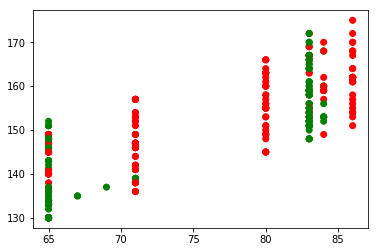

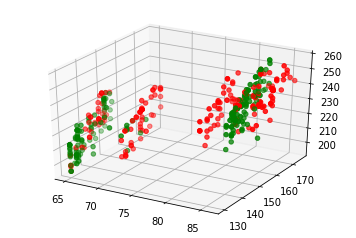

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D

with open("./acetylation_learning.txt", 'r') as f:
    training_data = [line.split() for line in f]
    
X = [line[1] for line in training_data]
labels = [line[2] for line in training_data]

def encode_labels(labels):
    y = list()
    for label in labels:
        if label == 'Ac':
            y.append(1)
        else:
            y.append(0)
    return y

y = np.array(encode_labels(labels))
            
def extract2D(seq):
    x1 = ord(seq[0])
    x2 = x1 + ord(seq[1])
    return (x1, x2)

def extract3D(seq):
    x1 = ord(seq[0])
    x2 = x1 + ord(seq[1])
    x3 = x2 + ord(seq[2])
    return (x1, x2, x3)

vect2D = np.vectorize(extract2D)
vect3D = np.vectorize(extract3D)

features2D = vect2D(X)
features3D = vect3D(X)

colors = list()
for cls in y:
    if cls:
        colors.append('g')
    else:
        colors.append('r')

plt.scatter(features2D[0], features2D[1], color=colors)
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(features3D[0], features3D[1], features3D[2], c=colors)

## Train Classifiers

In [5]:
from sklearn import svm
classifier = svm.SVC(C=7,
                     gamma=0.8,
                     kernel='rbf',
                     tol=1e-3,
                     shrinking=True,
                     probability=True
                    )
train2D_X = np.array(list(zip(features2D[0], features2D[1])))
train3D_X = np.array(list(zip(features3D[0], features3D[1], features3D[2])))
classifier.fit(train2D_X, y)


SVC(C=7, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.8, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Predictions

Accuracy:  0.8734793187347932


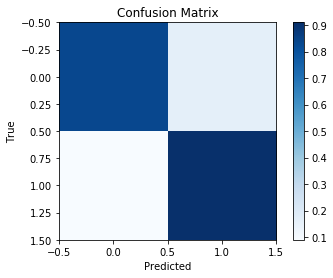

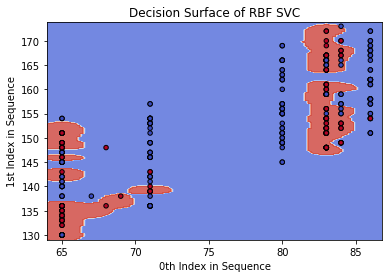

TPR: 0.835
SPC: 0.909952606635071
PPV: 1.032258064516129
AAC: 0.8734793187347932
MCC: 0.7480612152192719
 F1: 0.8652849740932642


In [6]:
import math
import itertools
from sklearn.metrics import confusion_matrix

with open("./acetylation_test.txt", 'r') as f:
    test_data = [line.split() for line in f]
    
test_X = [line[1] for line in test_data]
test_y = [line[2] for line in test_data]

test2D = vect2D(test_X)
test3D = vect3D(test_X)

test2D = np.array(list(zip(test2D[0], test2D[1])))
test3D = np.array(list(zip(test3D[0], test3D[1], test3D[2])))
test_y = np.array(encode_labels(test_y))

score = classifier.score(test2D, test_y)
print("Accuracy: ", score)

pred_y = classifier.predict(test2D)
cm = confusion_matrix(test_y, pred_y)

def plot_cm(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel("True")
    plt.xlabel("Predicted")
    
def make_meshgrid(x, y, h=0.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

plt.figure()
plot_cm(cm, classes=labels, normalize=True)

fig, ax = plt.subplots()
title = ("Decision Surface of RBF SVC")
X0, X1 = test2D[:, 0], test2D[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, classifier, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=test_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('1st Index in Sequence')
ax.set_xlabel('0th Index in Sequence')
ax.set_title(title)
plt.show()

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]

P = TP + FN
N = FP + TN

TPR = TP/P
SPC = TN/N
PPV = TN/(TP + FP)
AAC = (TP + TN)/(TP + FN + FP + TN)
MCC = ((TP * TN) - (FP * FN))/math.sqrt((TP + FN) * (FN + TN) * (TN + FP) * (FP + TP))
F1  = (2*TP)/(2*TP + FN + FP)

print(f'TPR: {TPR}')
print(f'SPC: {SPC}')
print(f'PPV: {PPV}')
print(f'AAC: {AAC}')
print(f'MCC: {MCC}')
print(f' F1: {F1}')